<a href="https://colab.research.google.com/github/ManishSuhas0026/Deep-Learning/blob/main/2348530_DL_Lab_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
df_train = pd.read_csv('/content/LSTM-Multivariate_pollution.csv')
df_train.head(5)

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB


In [4]:
df_test= pd.read_csv('/content/pollution_test_data1.csv')
df_test.head(5)

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,SE,3.58,0,0,128
1,-17,5,1027,SE,7.60,0,0,77
2,-16,4,1027,SE,9.39,0,0,65
3,-16,1,1028,cv,0.89,0,0,79
4,-14,0,1028,NE,1.79,0,0,93


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dew        346 non-null    int64  
 1   temp       346 non-null    int64  
 2   press      346 non-null    int64  
 3   wnd_dir    346 non-null    object 
 4   wnd_spd    346 non-null    float64
 5   snow       346 non-null    int64  
 6   rain       346 non-null    int64  
 7   pollution  346 non-null    int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 21.8+ KB


In [6]:
df_test.isnull().sum()

dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
pollution    0
dtype: int64

In [7]:
df_train.isnull().sum()

date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [8]:
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

mapping = {'NE': 0, 'SE': 1, 'NW': 2, 'cv': 3}

df_train_scaled['wnd_dir'] = df_train_scaled['wnd_dir'].map(mapping)
df_test_scaled['wnd_dir'] = df_test_scaled['wnd_dir'].map(mapping)

df_train_scaled['date'] = pd.to_datetime(df_train_scaled['date'])

df_train_scaled.set_index('date', inplace=True)
df_train_scaled.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,1,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,1,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,1,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,1,6.25,2,0


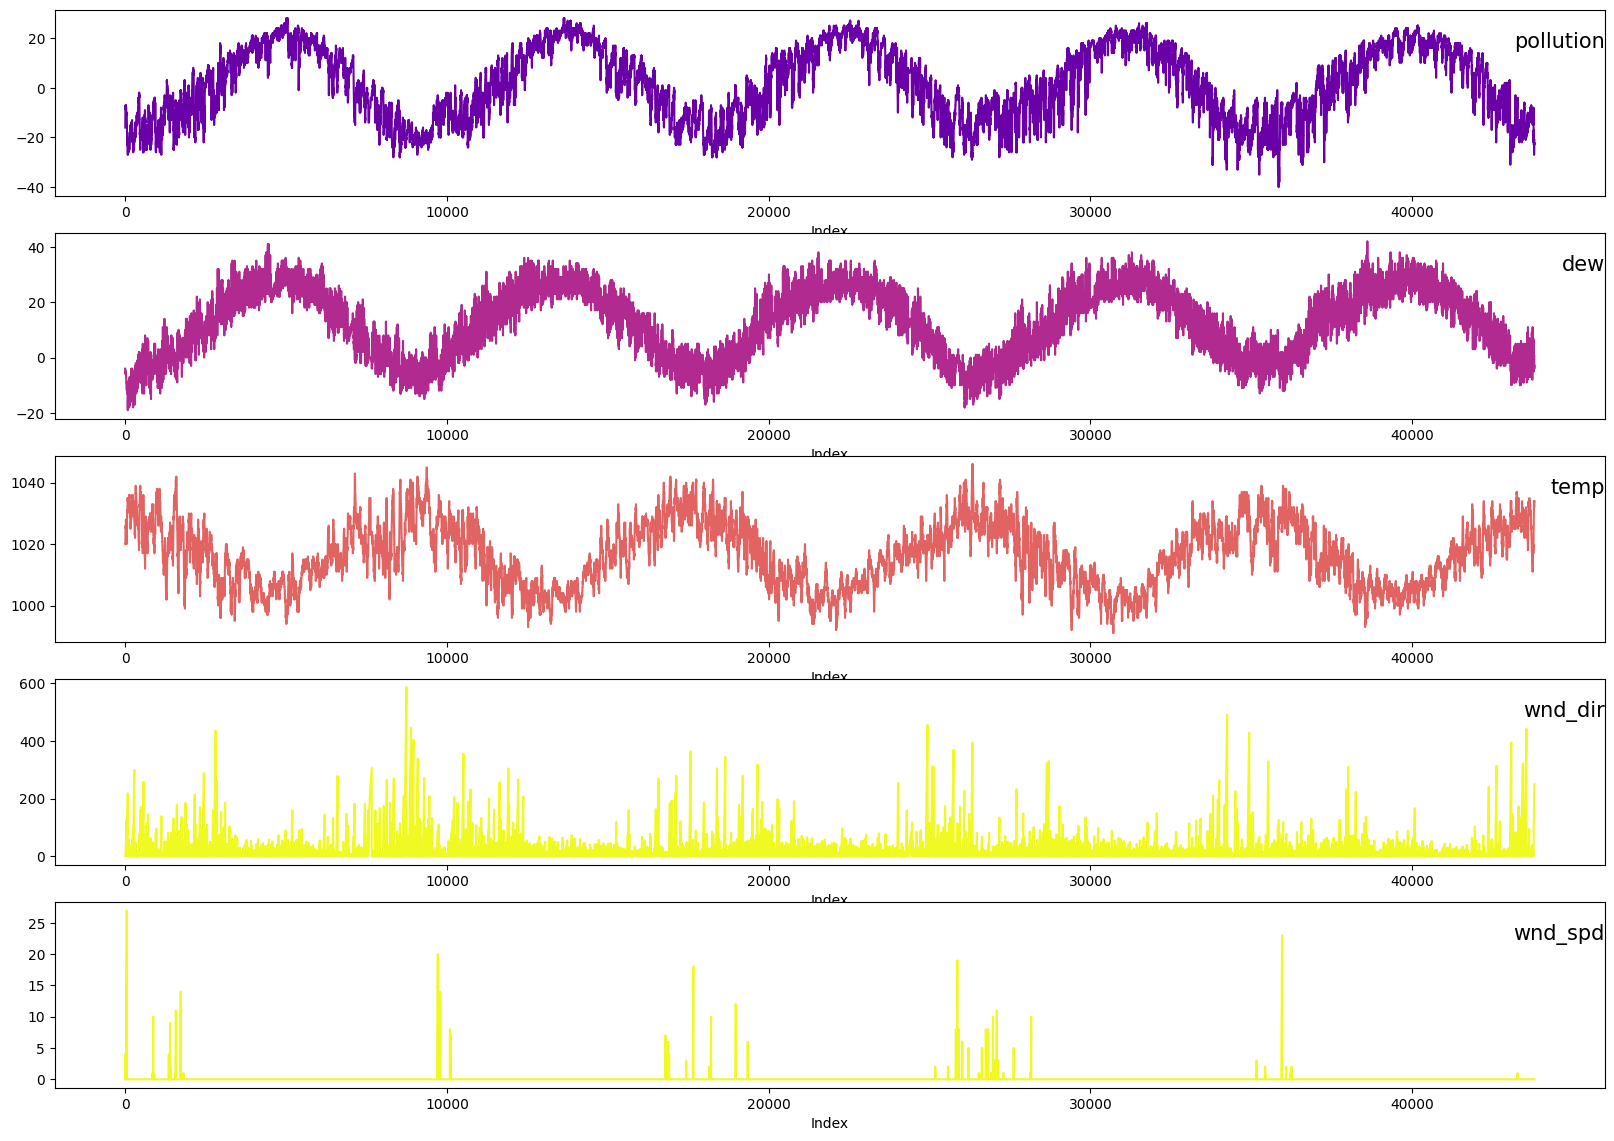

In [9]:
values = df_train_scaled.values
groups = [1, 2, 3, 5, 6]
i = 1

plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], color=cm.plasma(group/len(groups)))
    plt.xlabel('Index')
    plt.title(df_train.columns[group], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

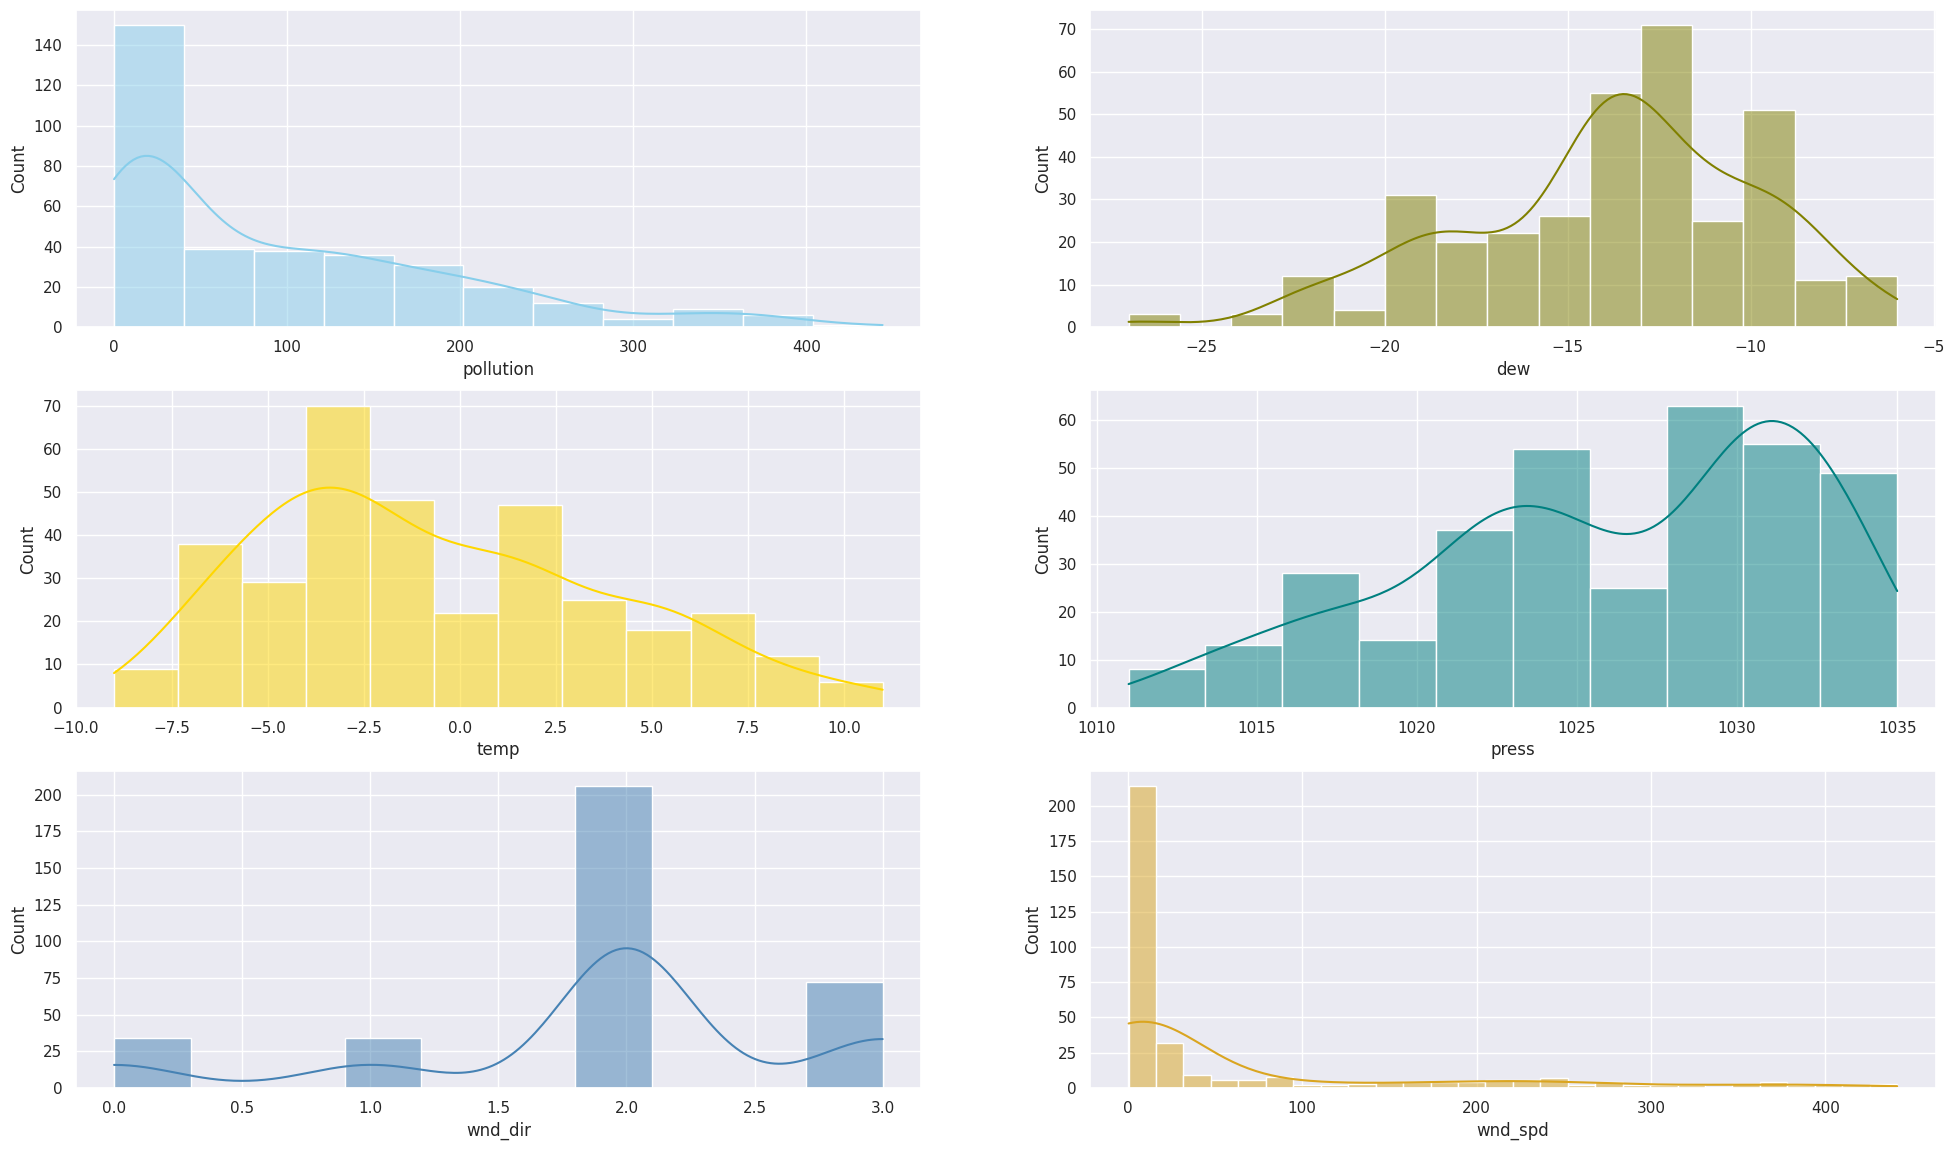

In [10]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(3,2, figsize=(24,14))

sns.histplot(data=df_test_scaled, x="pollution", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df_test_scaled, x="dew", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df_test_scaled, x="temp", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df_test_scaled, x="press", kde=True, color="teal", ax=axs[1, 1])
sns.histplot(data=df_test_scaled, x="wnd_dir", kde=True, color="steelblue", ax=axs[2, 0])
sns.histplot(data=df_test_scaled, x="wnd_spd", kde=True, color="goldenrod", ax=axs[2, 1])

plt.show()

In [11]:
scaler = MinMaxScaler()
columns = (['pollution', 'dew', 'temp', 'press', "wnd_dir", 'wnd_spd',
       'snow', 'rain'])

df_test_scaled = df_test_scaled[columns]

df_train_scaled[columns] = scaler.fit_transform(df_train_scaled[columns])
df_test_scaled[columns] = scaler.transform(df_test_scaled[columns])

df_train_scaled.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.333333,0.002290,0.000000,0.0
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.333333,0.003811,0.000000,0.0
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.333333,0.005332,0.000000,0.0
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.333333,0.008391,0.037037,0.0
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.333333,0.009912,0.074074,0.0


In [12]:
df_test_scaled.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,0.128773,0.352941,0.377049,0.654545,0.333333,0.005349,0.0,0.0
1,0.077465,0.338235,0.393443,0.654545,0.333333,0.012219,0.0,0.0
2,0.065392,0.352941,0.377049,0.654545,0.333333,0.015278,0.0,0.0
3,0.079477,0.352941,0.327869,0.672727,1.000000,0.000752,0.0,0.0
4,0.093561,0.382353,0.311475,0.672727,0.000000,0.002290,0.0,0.0


In [13]:
df_train_scaled = np.array(df_train_scaled)
df_test_scaled = np.array(df_test_scaled)

X = []
y = []
n_future = 1
n_past = 11

#  Train Sets
for i in range(n_past, len(df_train_scaled) - n_future+1):
    X.append(df_train_scaled[i - n_past:i, 1:df_train_scaled.shape[1]])
    y.append(df_train_scaled[i + n_future - 1:i + n_future, 0])
X_train, y_train = np.array(X), np.array(y)

#  Test Sets

X = []
y = []
for i in range(n_past, len(df_test_scaled) - n_future+1):
    X.append(df_test_scaled[i - n_past:i, 1:df_test_scaled.shape[1]])
    y.append(df_test_scaled[i + n_future - 1:i + n_future, 0])
X_test, y_test = np.array(X), np.array(y)

print('X_train shape : {}   y_train shape : {} \n'
      'X_test shape : {}      y_test shape : {} '.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train shape : (43789, 11, 7)   y_train shape : (43789, 1) 
X_test shape : (335, 11, 7)      y_test shape : (335, 1) 


In [14]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(y_train.shape[1]))


model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 11, 32)            5120      
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 8273 (32.32 KB)
Trainable params: 8273 (32.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping, checkpoint], shuffle=False)

Epoch 1/100
1232/1232 [==============================] - 16s 13ms/step - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1070
Epoch 2/100
  12/1232 [..............................] - ETA: 12s - loss: 0.0102 - root_mean_squared_error: 0.1011

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1232/1232 [==============================] - 13s 10ms/step - loss: 0.0067 - root_mean_squared_error: 0.0821 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1052
Epoch 3/100
1232/1232 [==============================] - 13s 10ms/step - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074
Epoch 4/100
1232/1232 [==============================] - 13s 10ms/step - loss: 0.0063 - root_mean_squared_error: 0.0796 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1021
Epoch 5/100
1232/1232 [==============================] - 13s 11ms/step - loss: 0.0062 - root_mean_squared_error: 0.0785 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 6/100
1232/1232 [==============================] - 13s 11ms/step - loss: 0.0060 - root_mean_squared_error: 0.0776 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1027
Epoch 7/100
1232/1232 [==============================] - 13s 10ms/step - loss: 0.0059 - root_mean_squared_error: 0.0769 - val_l

In [17]:
best_model = load_model('best_model.h5')

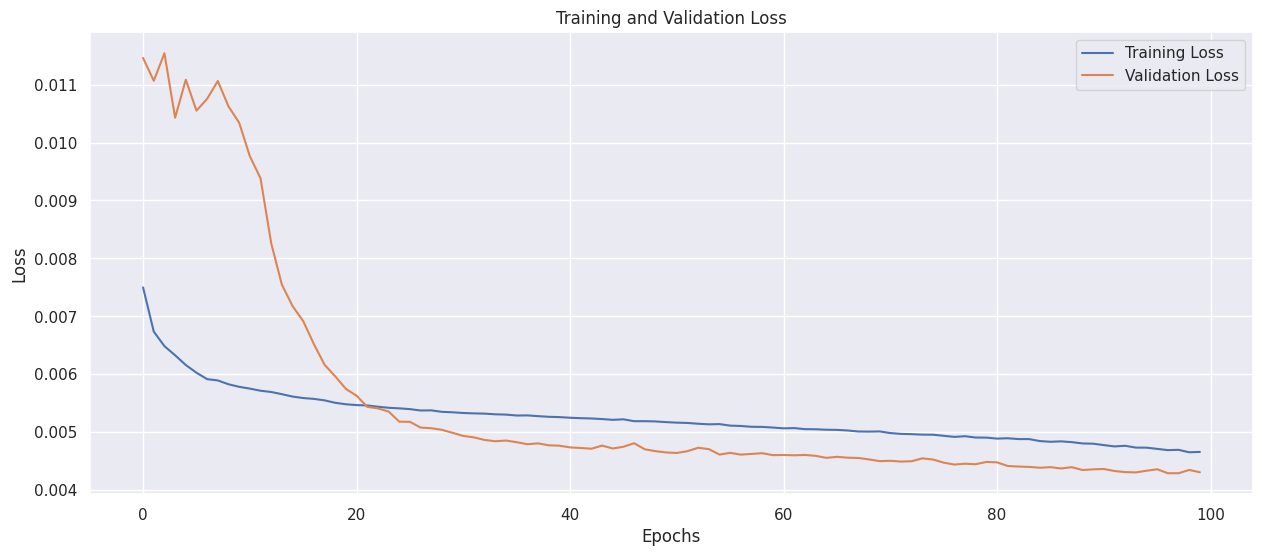

In [18]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
test_predictions = best_model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test.flatten()})
test_results.head()

11/11 [==============================] - 2s 3ms/step


,Train Predictions,Actual
0,0.116101,0.171026
1,0.087417,0.160966
2,0.109336,0.146881
3,0.117941,0.125755
4,0.093616,0.130785


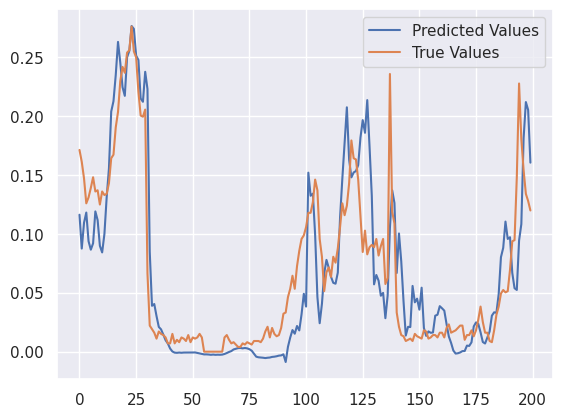

In [20]:
plt.plot(test_results['Train Predictions'][:200], label='Predicted Values')
plt.plot(test_results['Actual'][:200], label='True Values')
plt.legend()
plt.show()